# **Pós Tech, fase 4: Modelo de Machine Learning que faz a previsao do preco do petróleo diariamente**


# **Importando as bibliotecas**

Vamos começar a nossa análise importando as principais bibliotecas que vamos utilizar na nossa análise, tais como: pandas, numpy, matplotlib, seaborn, etc.
As demais bibliotecas serão utilizadas conforme as necessidades dos testes.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sb
from statsmodels.tsa.seasonal import seasonal_decompose

# **Importando o dataset para o notebook**

Agora vamos realizar a importação da nossa base de dados que está em csv para o colab e começar a conhecer os dados.

In [23]:
df = pd.read_csv("/content/FIAP_PRECO_PETROLEO.csv", sep = ",")

# **Conhecendo o dataset**

Fizemos a escolha dos nossos dados por meio do site da [ipea](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view) segmentando para trazer os dados dos so século atual (04/01/2000 até 13/05/2024).

In [24]:
# Com o head conseguimos verificar as colunas que temos no dataset e os dados mais atuais
df.head()

,Data,Último
0,13/05/2024,"83,18"
1,10/05/2024,"83,39"
2,09/05/2024,"83,27"
3,08/05/2024,"82,44"
4,07/05/2024,"82,69"


In [25]:
# Com o tail podemos verificar que todos os nosos dados foram gerados corretamente, dado que a última linha é de 04/01/2000
df.tail()

,Data,Último
7964,10/01/2000,"22,77"
7965,07/01/2000,"23,35"
7966,06/01/2000,"23,55"
7967,05/01/2000,"23,72"
7968,04/01/2000,"23,95"


In [26]:
# Shape para saber a quantidade extas de linhas e colunas
df.shape

(7969, 2)

In [27]:
#Com o df.info, conseguimos notar que a data está como object, assim como o valor de fechamento do dia (último), o que é um problema que precisaremos solucionar.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7969 entries, 0 to 7968
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7969 non-null   object
 1   Último  7969 non-null   object
dtypes: object(2)
memory usage: 124.6+ KB


# **Manipulando os dados**

Aqui vamos realizar as primeiras validações para descobrir se temos dados em branco, dados repetidos e fazer algumas transformações nos dados caso sejam necessárias.

In [28]:
# Não exite nenhum linha em branco
df.isna().sum()

Data      0
Último    0
dtype: int64

In [29]:
#Não temos linhas duplicadas no nosso dataset
df.duplicated().sum()

0

In [30]:
# Como podemos notar a coluna 'Data' está no dataset como object(texto), nesse caso precisamos formatá-la para datetime.
print(df.dtypes)

Data      object
Último    object
dtype: object


In [31]:
#Convertendo a 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

In [32]:
df

,Data,Último
0,2024-05-13,"83,18"
1,2024-05-10,"83,39"
2,2024-05-09,"83,27"
3,2024-05-08,"82,44"
4,2024-05-07,"82,69"
...,...,...
7964,2000-01-10,"22,77"
7965,2000-01-07,"23,35"
7966,2000-01-06,"23,55"
7967,2000-01-05,"23,72"


In [33]:
#Convertendo o valor do petroleo para float64 além de corrigir o separador decimal
df['Último'] = df['Último'].str.replace(',', '.')
df['Último'] = pd.to_numeric(df['Último'], errors='coerce')

In [34]:
# Verificando alterações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7969 entries, 0 to 7968
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    7969 non-null   datetime64[ns]
 1   Último  7969 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 124.6 KB


# **Visualizando os dados**

Vamos entender melhor as informações que encontramos e tirar insghts com algumas visualizações do matplotlib

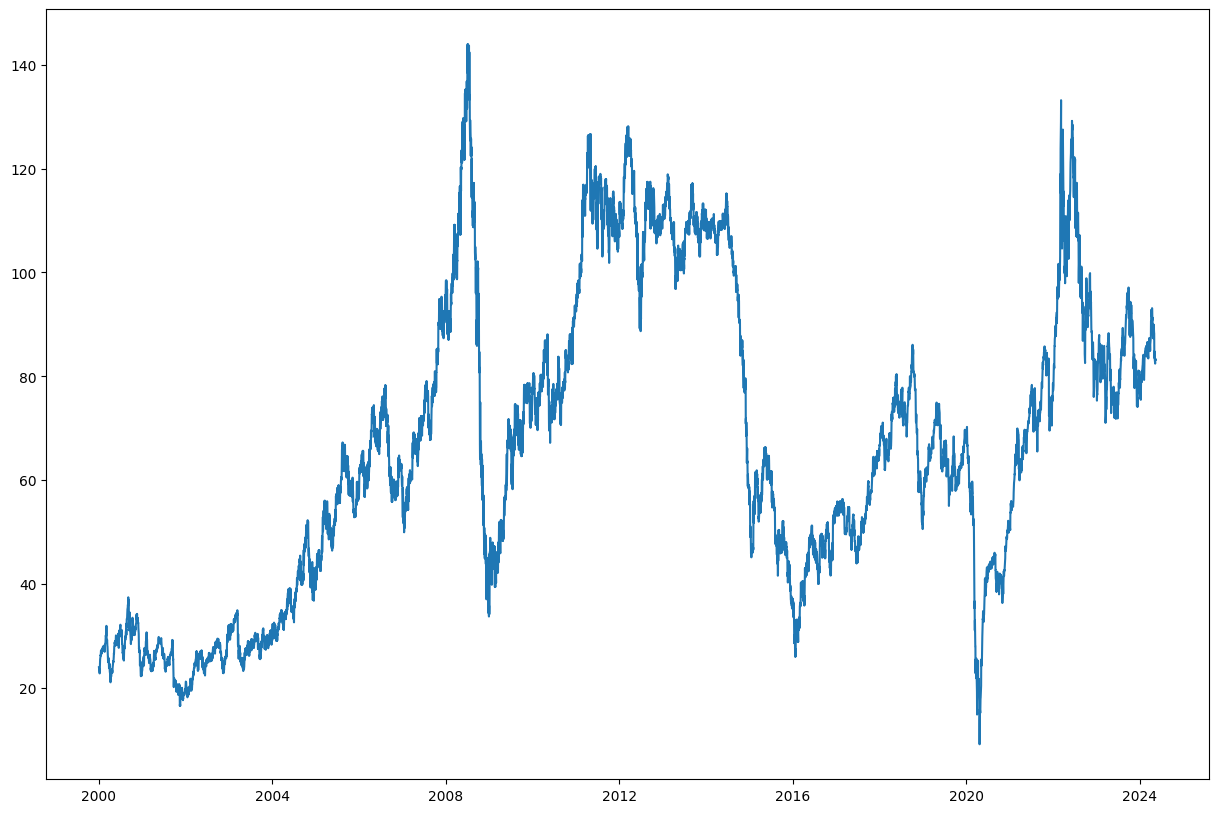

In [35]:
# primeiro plot

plt.figure(figsize = (15,10))
plt.plot(df['Data'], df['Último'], label='PRETROLEO')

plt.show()

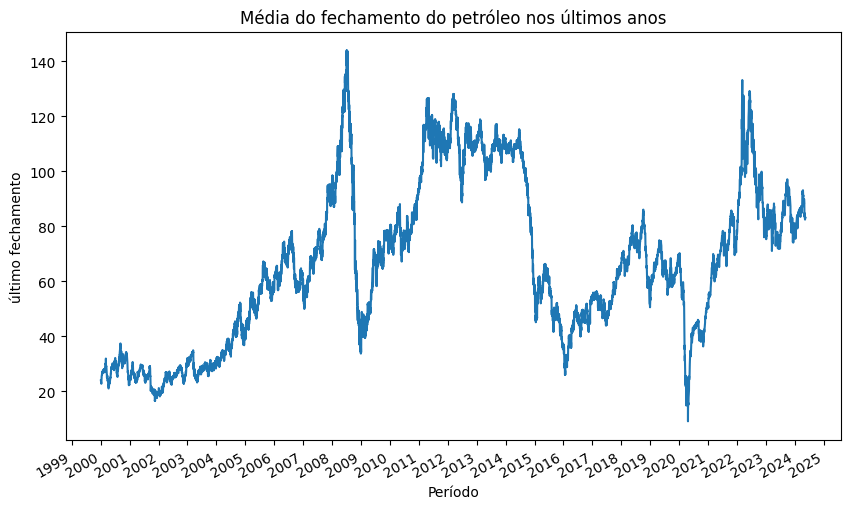

In [36]:
# Melhorando o plot para poder analisar melhor, aqui de cara podemos notar que a série não é nada regular, isso já nos direciona um pouco qual modelo escolher no final.
# Tivemos um pico gigantesco em 2008, gerando a maior alta, seguido de uma queda drática, o que será que aconteceu?

plt.figure(figsize=(10, 6))
plt.plot(df['Data'], df['Último'])
plt.ylabel('último fechamento')
plt.xlabel('Período')
plt.title('Média do fechamento do petróleo nos últimos anos')

# Define um formato de data para mostrar apenas o ano
date_format = mdates.DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Mostra rótulos a cada ano
plt.gcf().autofmt_xdate()  # Ajusta a inclinação para melhorar a legibilidade

plt.show()

# Podemos notar uma variação muito grande em todos os anos, o petróleo sofre muitas influências não só na eferta e demanda, mas também na macro economia, sendo muito
# influenciado por guerras, juros altos, tensões politicas e etc.

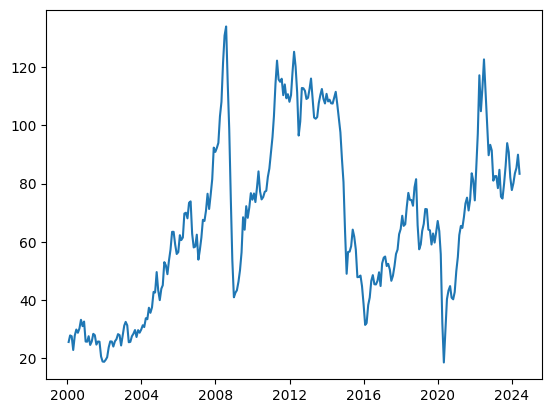

In [37]:
# Modificando o index para facilitar a utilização do resample, aqui podemos notar que na média mensal também tem muita variação, o que signifca que não isso não se limita aos dias, mas sim a série como um todo.

df.set_index('Data', inplace=True)
df_resampled = df['Último'].resample('M').mean()  # Resample para média mensal
plt.plot(df_resampled.index, df_resampled)


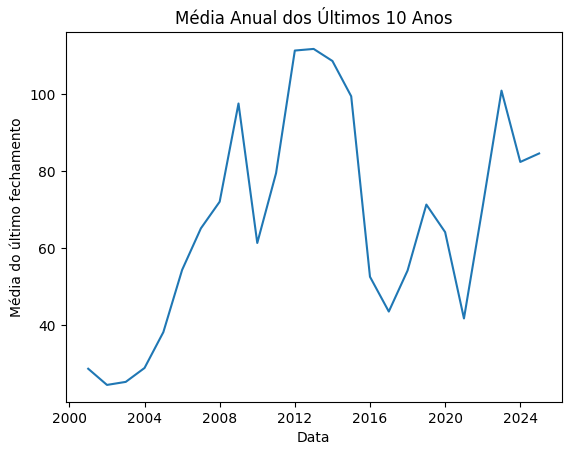

In [38]:
# A média anual dos últimos também oscilou muito, possivelmente essa será a nossa têndencia no resultado final do modelo.
df_resampled_annual_10_years = df['Último'].resample('Y').mean()  # Resample para média anual
plt.plot(df_resampled_annual_10_years.index, df_resampled_annual_10_years)
plt.title('Média Anual dos Últimos 10 Anos')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')
plt.show()

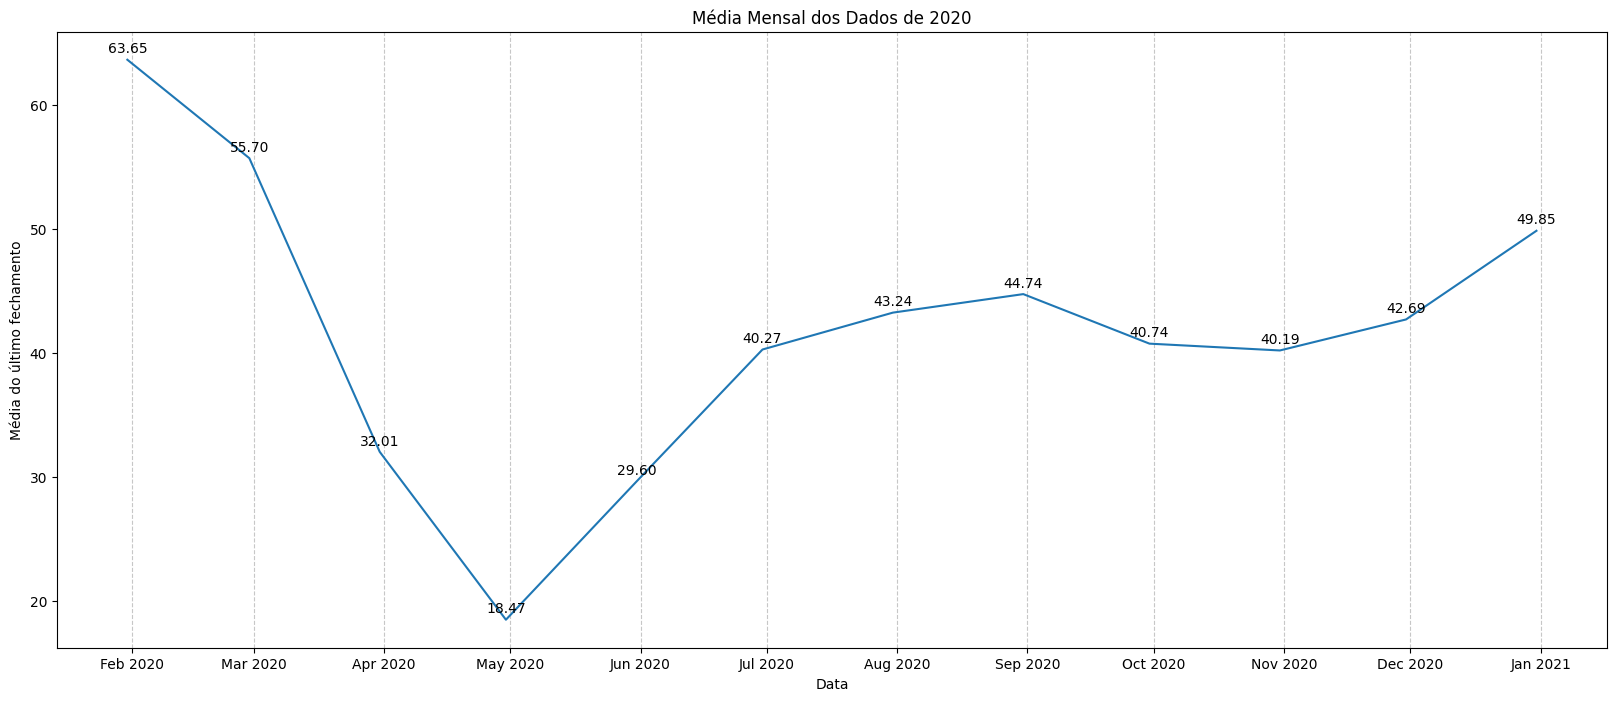

In [39]:
# Criar um novo DataFrame contendo apenas os dados de 2020 para analisar um pouco melhor a queda na época da pandemia.
df_2020 = df[df.index.year == 2020]

# Resample para média mensal
df_2020_resampled_monthly = df_2020['Último'].resample('M').mean()

# Plotar os dados mensais de 2020 com mais ticks no eixo x e linhas de grade
plt.figure(figsize=(20, 8))
plt.plot(df_2020_resampled_monthly.index, df_2020_resampled_monthly)
plt.title('Média Mensal dos Dados de 2020')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_2020_resampled_monthly.index, df_2020_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

# Em 2020 tivemos uma das piores pandemia da história, a pandemia do Corona Virus. A incerteza no cenário mundial afetou diretamente o preço de praticamente todos os ativos
# do mundo e com o petróleo não foi diferente, chegando a bater 18.47 dolares em maio, um dos valores mais baixos da série histórica.

In [40]:
df_2020_resampled_monthly.to_csv('df_2020_resampled_monthly.csv', index=True)

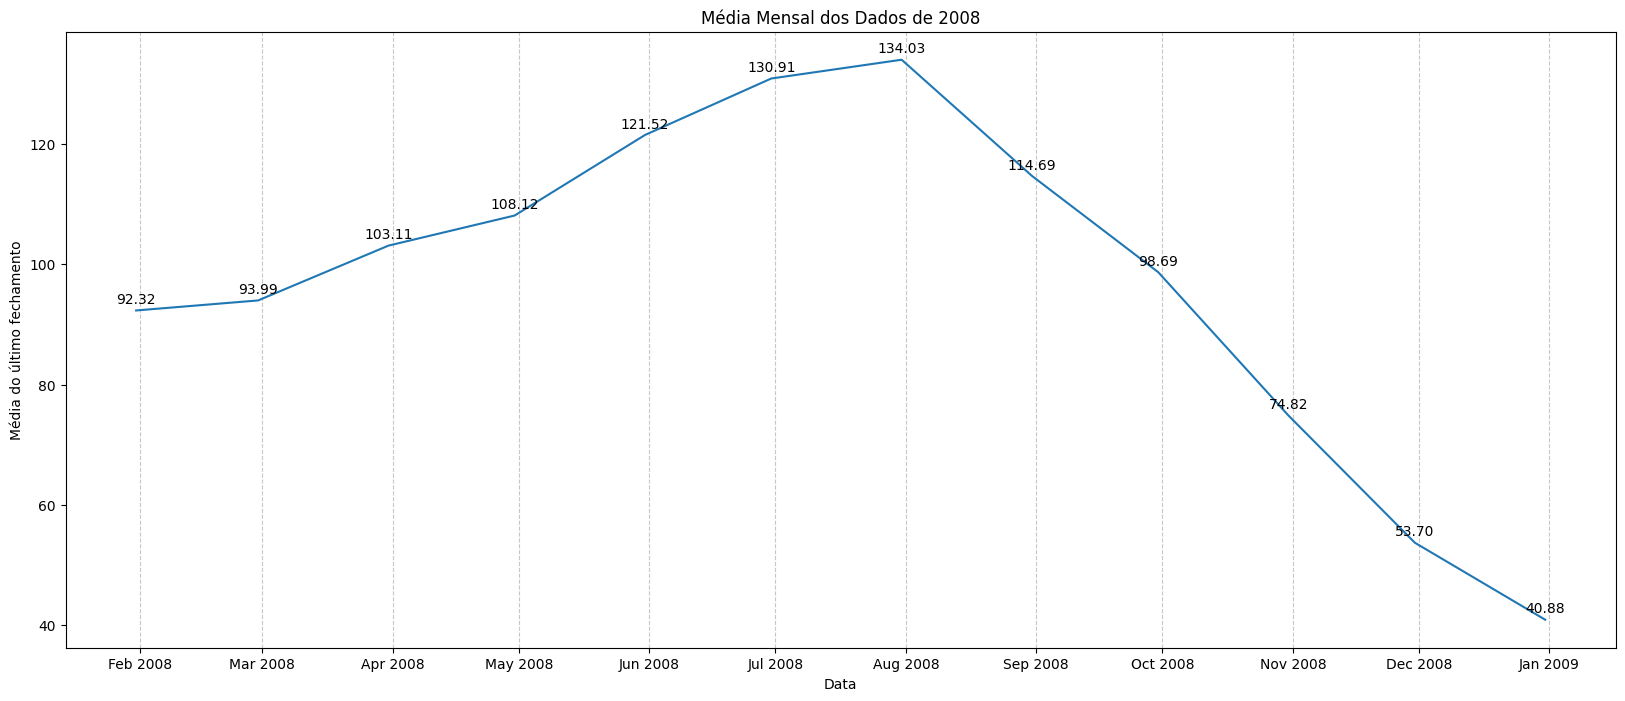

In [41]:
# Criar um novo DataFrame contendo apenas os dados de 2008 para analisar um pouco melhor a queda na época da pandemia.
df_2008 = df[df.index.year == 2008]

# Resample para média mensal
df_2008_resampled_monthly = df_2008['Último'].resample('M').mean()

# Plotar os dados mensais de 2008 com mais ticks no eixo x e linhas de grade
plt.figure(figsize=(20, 8))
plt.plot(df_2008_resampled_monthly.index, df_2008_resampled_monthly)
plt.title('Média Mensal dos Dados de 2008')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_2008_resampled_monthly.index, df_2008_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

# Em 2008 houve uma crise financeira mundial que atingiu paises de todos os continentes do mundo, foi uma crise gerada pela alta dos juros que ocasionou
# muita oferta por crédito e pouca procura, resultando no colápso de várias instiuições financeiras e imobiliárias.
# Até hoje essa crise financeira é considerada uma das piores da história e podemos notar a variação drástica do preço do barril de petróleo, saindo de aproximadamente
# 90 dólares, passando para 134 com uma alta de mais 40% e depois seguido por uma queda para 40 dólares, uma incrivel queda abrupta de quase 75%

In [42]:
df_2008_resampled_monthly.to_csv('df_2008_resampled_monthly.csv', index=True)

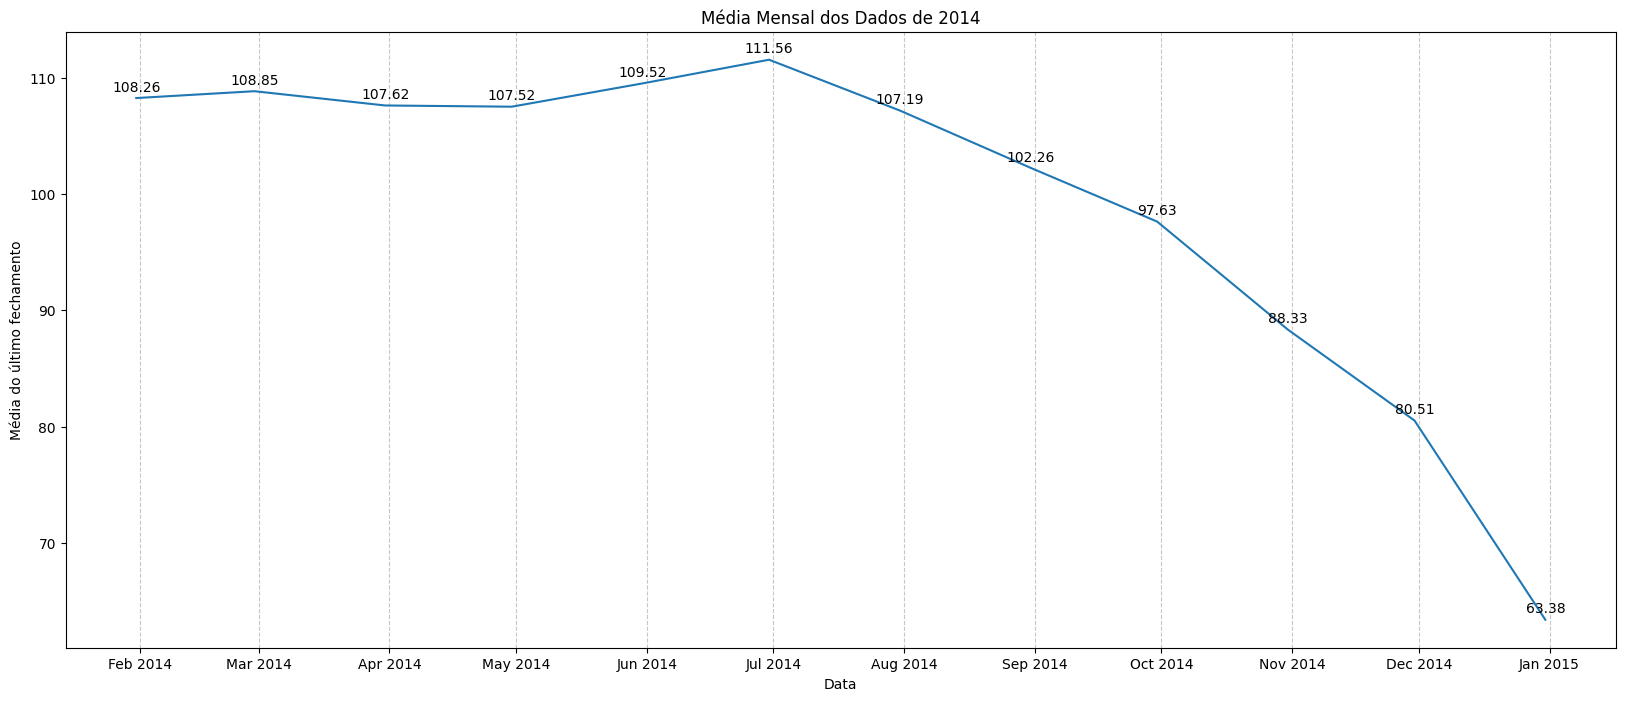

In [43]:
# Criar um novo DataFrame contendo apenas os dados de 2014 para analisar um pouco melhor a queda na época da pandemia.
df_2014 = df[df.index.year == 2014]

# Resample para média mensal
df_2014_resampled_monthly = df_2014['Último'].resample('M').mean()

# Plotar os dados mensais de 2014 com mais ticks no eixo x e linhas de grade
plt.figure(figsize=(20, 8))
plt.plot(df_2014_resampled_monthly.index, df_2014_resampled_monthly)
plt.title('Média Mensal dos Dados de 2014')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_2014_resampled_monthly.index, df_2014_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

# Em 2014, diferente dos outros insights que trouxemos, não houve uma grande crise global que gerassem a variação no preço do petróleo, aqui tivemos um aumento da
# produção norte americana que atingiu a sua máxima em 30 anos, e esse aumento da oferta não foi seguido pela demanda, dado que os paises europeus e asiáticos não tiveram
# o almento esperado no consumo. Como tinha muito petróleo sendo produzido e pouco sendo consumido, os preços acabaram caindo quase 50% em menos de 6 meses.

In [44]:
df_2014_resampled_monthly.to_csv('df_2014_resampled_monthly.csv', index=True)

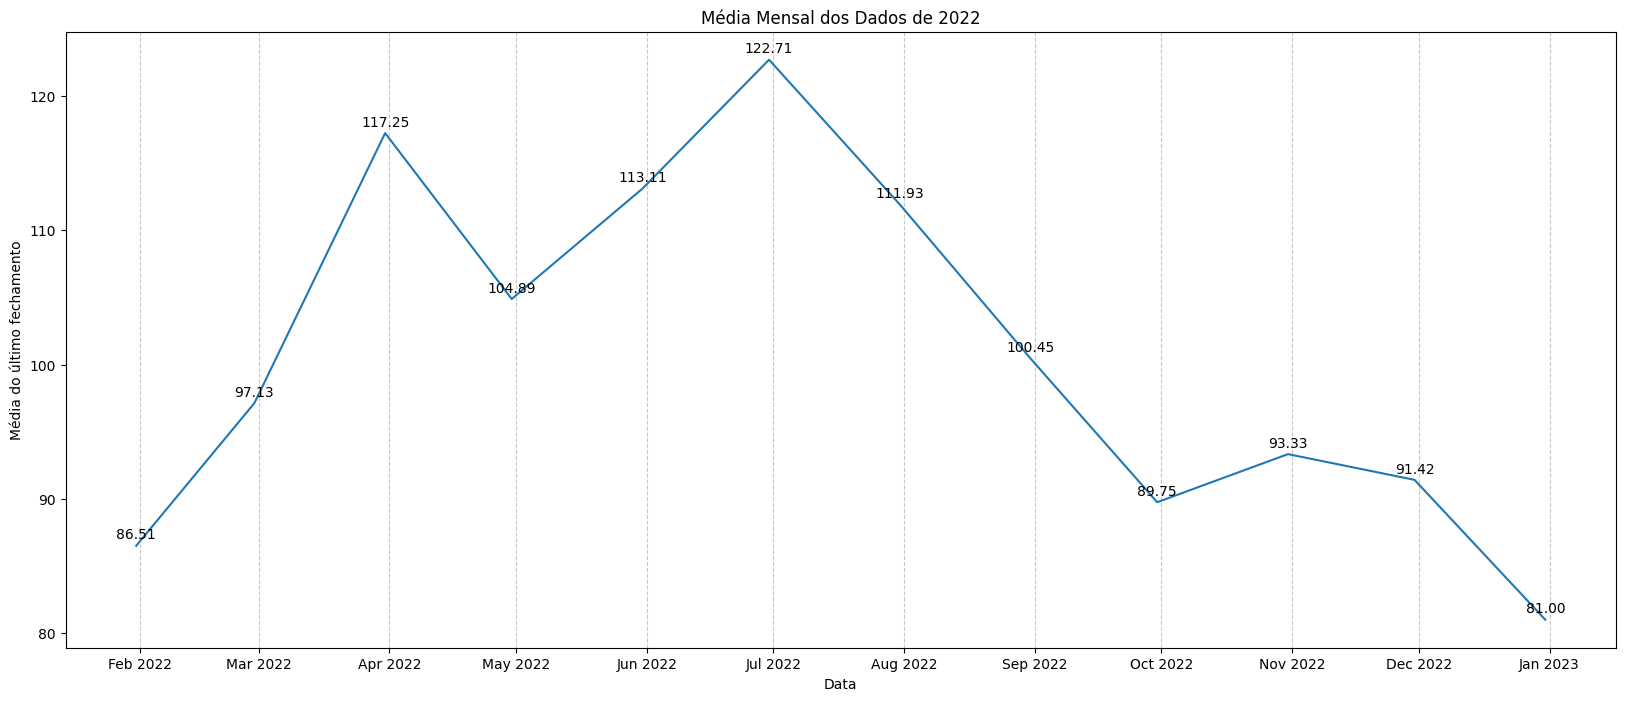

In [45]:
# Criar um novo DataFrame contendo apenas os dados de 2022 para analisar um pouco melhor a queda na época da pandemia.
df_2022 = df[df.index.year == 2022]

# Resample para média mensal
df_2022_resampled_monthly = df_2022['Último'].resample('M').mean()

# Plotar os dados mensais de 2022 com mais ticks no eixo x e linhas de grade
plt.figure(figsize=(20, 8))
plt.plot(df_2022_resampled_monthly.index, df_2022_resampled_monthly)
plt.title('Média Mensal dos Dados de 2022')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_2022_resampled_monthly.index, df_2022_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

# Em 2022 tivemos uma grande alta no preço do petróleo por conta da guerra entre Russia e Ucrânia, essa alta foi calsada pelo fato da Russia ser o segundo maior produtor
# de pretróleo do mundo e por conta da invasão a Ucrânia eles sofreram fortes sansoes de vários países contrários. Essas sansões dificultavam a exportação do petróleo
# Russo, gerando assim uma incerteza no mercado e a grande alta, chegando a atingir valores acima de 122 doláres, patamar não alcançado desde 2014.

In [46]:
df_2022_resampled_monthly.to_csv('df_2022_resampled_monthly.csv', index=True)

# **Decompondo a série temporal**

Agora vamos entender um pouco da **Tendência**, **Sazonalidade**, **Ruído** e se a série é **aditiva** ou **multiplicativa**.

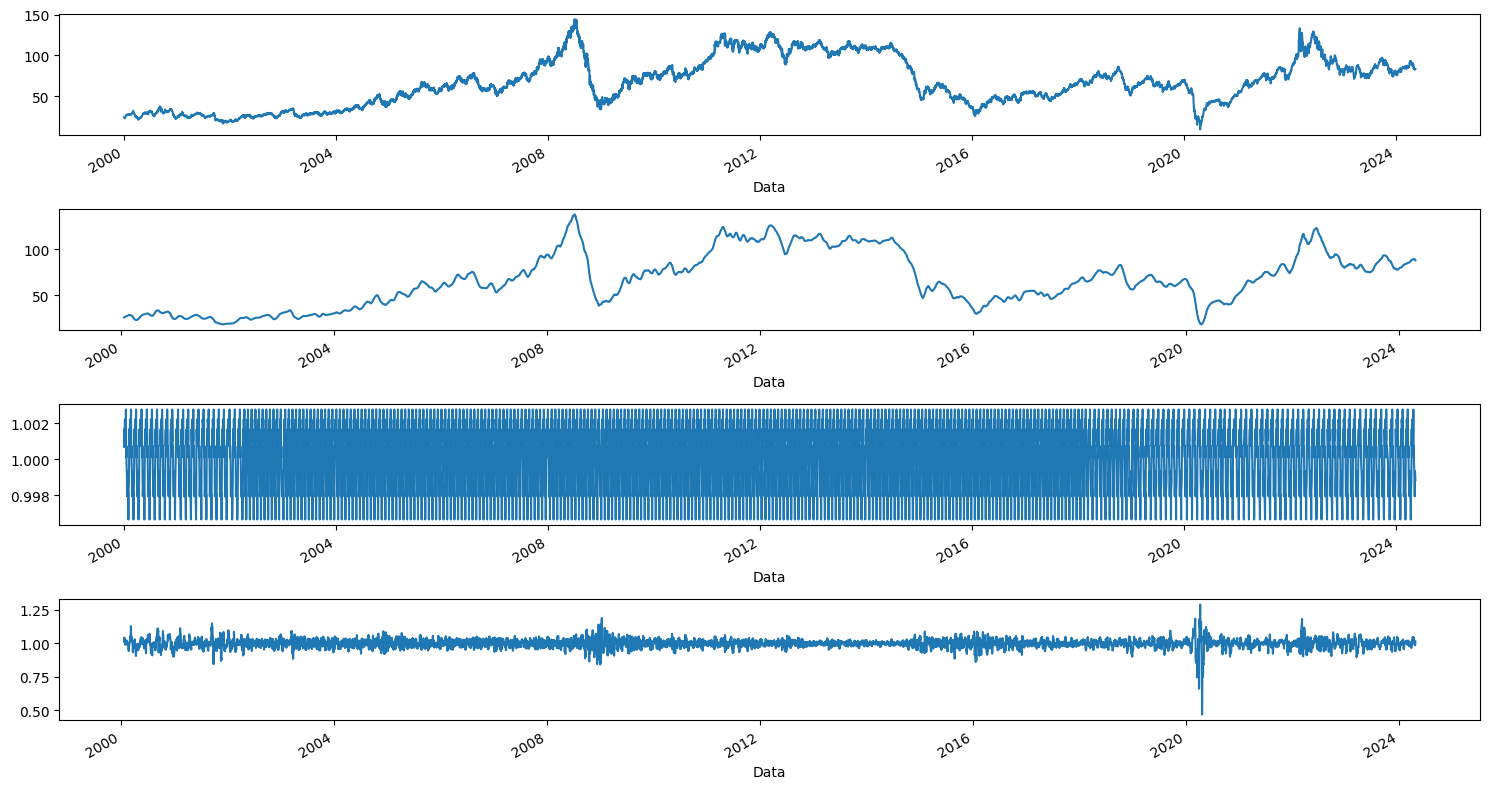

In [47]:
df_limpo = df # cópia do dataframe

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=25)  #decopondo a série temporal, colocamos period=25, depois de fazer alguns testes, essa quantidade pareceu mostrar a realidade dos dados.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

Com os gráficos assima podemos notar que a série possui uma leve tendência de alta no decorrer dos anos, mesmo com as grandes oscilações, Além disso, não fica muito claro os periodos de sazonalidade, indicando que há variação, mas que não ocorrem com algum padrão. e acabamos encontrando muitos residuos, principalmente em 2008 que foi marcado pela crise global e 2020 quando houve a pandemia.

Assim podemos ter certeza que a série é Multiplicativa e possui muita variação ao longo do tempo

# **Testando alguns modelos**

Agora que já endendemos os nossos dados vamos partir para o teste de alguns modelos para identificar quais performam melhor.

  # **Média Móvel**

In [48]:
# Criando uma média móvel com base nos últimos 10 e 20 dias.
df_limpo['MA_window_10'] = df_limpo['Último'].rolling(10).mean().shift() #média móvel em 10 dias
df_limpo['MA_window_20'] = df_limpo['Último'].rolling(20).mean().shift() #média móvel em 20 dias

In [49]:
df_limpo.head(30)

,Último,MA_window_10,MA_window_20
Data,,,
2024-05-13,83.18,NaN,NaN
2024-05-10,83.39,NaN,NaN
2024-05-09,83.27,NaN,NaN
2024-05-08,82.44,NaN,NaN
2024-05-07,82.69,NaN,NaN
2024-05-03,83.60,NaN,NaN
2024-05-02,84.81,NaN,NaN
2024-05-01,83.55,NaN,NaN
2024-04-30,88.23,NaN,NaN


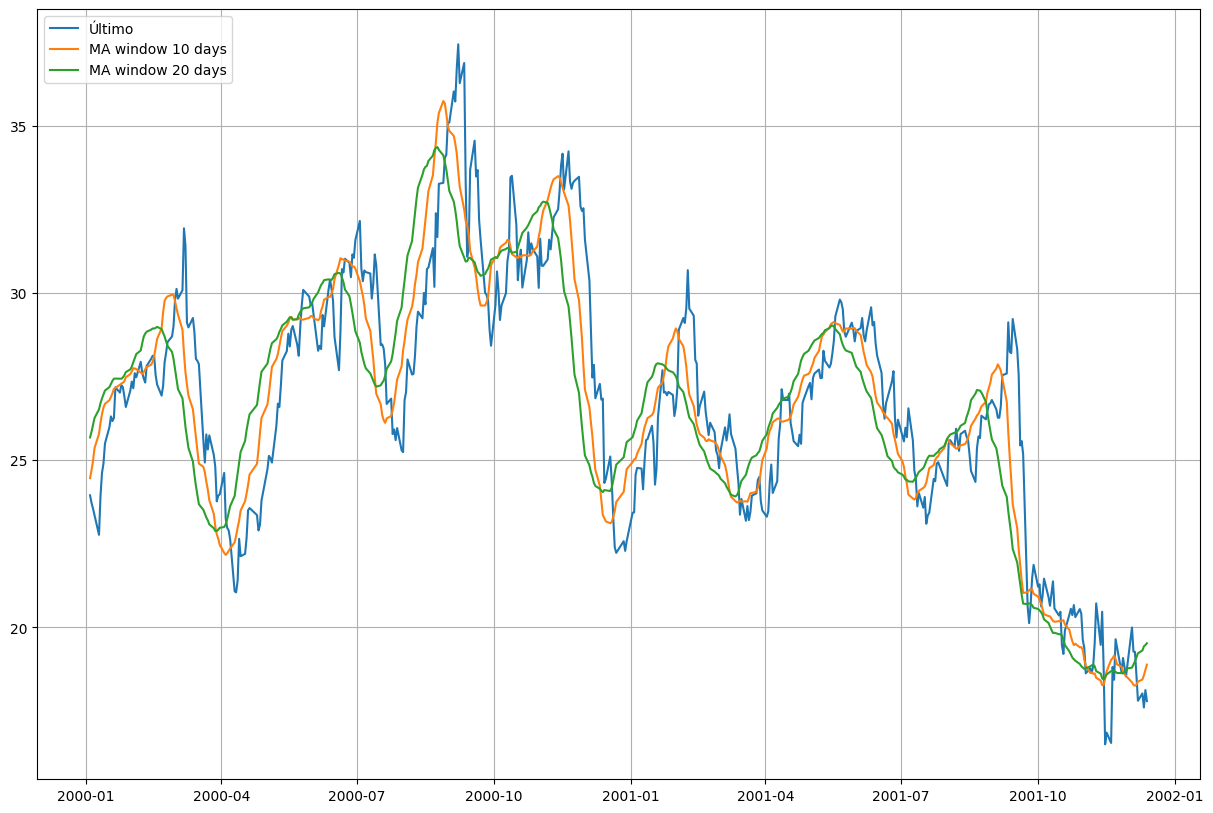

In [50]:
# Plotando os resultados da nossa série e da média móvel podemos notar que até acertamos a têndencia, mas não conseguimos prever com exatidão o valor real.

limit = 500

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_limpo['Último'][-limit:], label='Último')
plt.plot(df_limpo['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df_limpo['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

Levando em consideração que a nossa série é muito volátil e que já conseguimos notar que não acetamos com exatidão a previsão com as médias de 10 e 20 dias, não vamos seguir com o treinamento deste modelo.

Como a idéia é prever os próximos dias e meses, com esse método e o passar do tempo, teriamos resultados desconéxos da realidade, por utiliziar simplesmente a média dos últimos dias.

  # **Arima**

In [51]:
# limpando novamente o df para o novo modelo
df_limpo = df.drop(columns=['MA_window_10', 'MA_window_20'])
df_limpo.head()

,Último
Data,
2024-05-13,83.18
2024-05-10,83.39
2024-05-09,83.27
2024-05-08,82.44
2024-05-07,82.69


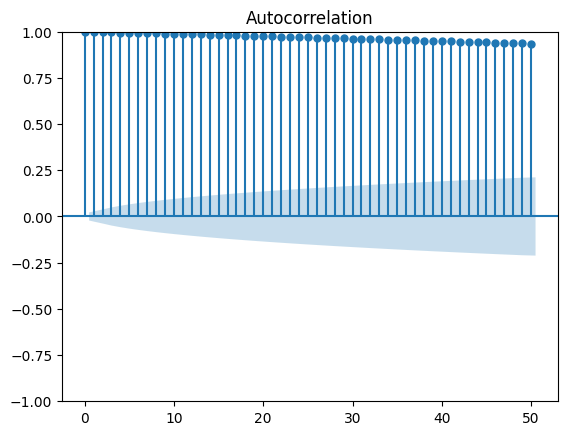

In [52]:
# verificando o gráfico de auto correlação ACF, podemos notar que existe uma correlação com os dados, seja indireta ou direta.
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

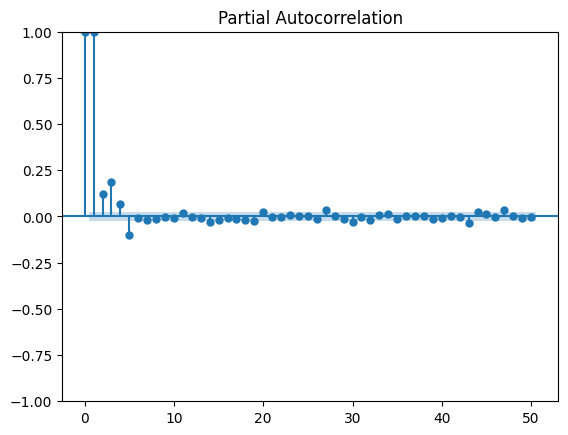

In [53]:
# já utilizando o PACF para a correlação direta, podemos notar que não existe uma correlação.
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

In [54]:
#Criando dois novos df para verificar a média móvel e o desvio padrão dos dados.

rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

               Último
Data                 
2024-05-13        NaN
2024-05-10        NaN
2024-05-09        NaN
2024-05-08        NaN
2024-05-07        NaN
...               ...
2000-01-10  25.657500
2000-01-07  25.333333
2000-01-06  25.044167
2000-01-05  24.755833
2000-01-04  24.563333

[7969 rows x 1 columns]               Último
Data                
2024-05-13       NaN
2024-05-10       NaN
2024-05-09       NaN
2024-05-08       NaN
2024-05-07       NaN
...              ...
2000-01-10  1.376346
2000-01-07  1.426912
2000-01-06  1.405473
2000-01-05  1.276461
2000-01-04  1.200949

[7969 rows x 1 columns]


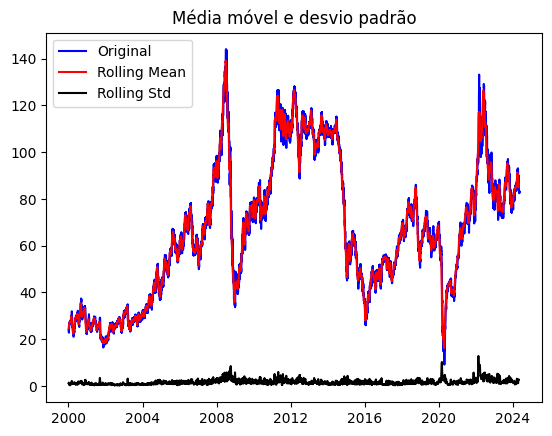

In [55]:
#Plotando a média móvel e o desvio padrão podemos perceber que a serie não é estácionária, pois a média móvel está muito distante do desvio padrão.
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

In [56]:
# utilizando o Teste de Dickey-Fuller podemos comprovar estatisticamente que a série não é estácionária, pois os valores críticos estão abaixo das ADF Statistic e o valor de p não é abaixo de 0.05
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Último'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.087569137532992
p-value: 0.24954240268030237
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.087569137532992
Valor-p: 0.24954240268030237
Valores Críticos:
   1%: -3.4311741673385154
   5%: -2.861904222513106
   10%: -2.566963870972919


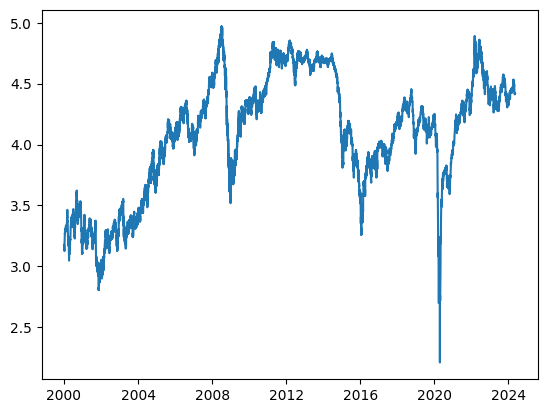

In [57]:
#Utilizando o logaritmo, vamos realizar a transformação dos dados para tentar deixar a série como estacionária.
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

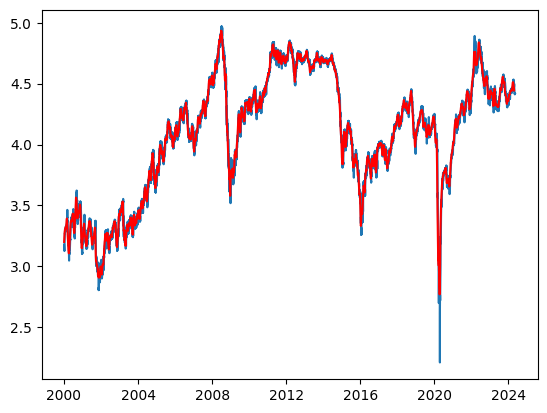

In [58]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [59]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Último
Data,
2024-04-25,0.034665
2024-04-24,0.039399
2024-04-23,0.026406
2024-04-22,0.011191
2024-04-19,0.013322
2024-04-18,0.012125
2024-04-17,0.019897
2024-04-16,0.033118
2024-04-15,0.021205


In [60]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Último'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


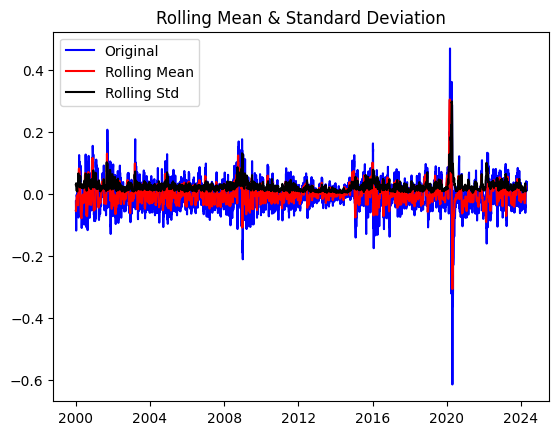

Results of Dickey Fuller Test:
Test Statistic                -1.497567e+01
p-value                        1.182297e-27
#Lags Used                     3.000000e+01
Number of Observations Used    7.927000e+03
Critical Value (1%)           -3.431175e+00
Critical Value (5%)           -2.861905e+00
Critical Value (10%)          -2.566964e+00
dtype: float64


In [61]:
# Aqui podemos notar que a série ficou estácionária, pois o p valor ficou bem menor do que 0.05, sendo igual a 0.000000000000000000000000001182297.
test_stationarity(datasetLogScaleMinusMovingAverage)

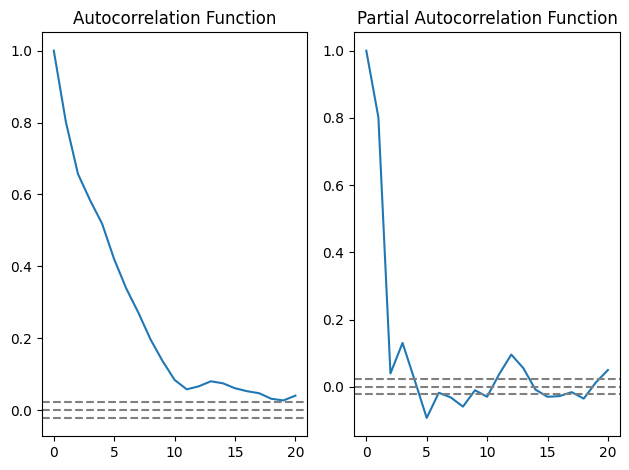

In [62]:
# encontrando os valores de P e Q para os hiperparametros do Arima, analisando os gráficos podemos notar que Q = 18, P = 2 e como só fizemos uma transformação na série o I = 1

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogScaleMinusMovingAverage, nlags=20)
lag_pacf = pacf(datasetLogScaleMinusMovingAverage, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

In [ ]:
#Configurando o arima e verificando a soma dos quadrados residuos

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(datasetLogScaleMinusMovingAverage, order=(2,1,18))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogScaleMinusMovingAverage)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogScaleMinusMovingAverage['Último'])**2))
print('Plotting AR model')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
# Calculando o MAPE do resultado do arima, como podemos notar o MAPE foi muito alto, sendo assim, o modelo não performou bem.

from sklearn.metrics import mean_absolute_error

predictions = results_AR.fittedvalues
predictions.index = datasetLogScaleMinusMovingAverage.index
predicted_values = indexedDataset_logScale['Último'].iloc[0] + np.cumsum(predictions)

mape = mean_absolute_error(datasetLogScaleMinusMovingAverage['Último'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

  # **Prophet**

In [ ]:
#recriando o df do zero para evitar dados manipulados e já criando as colunas padrões do Prophet: ds e y
df = pd.read_csv("/content/FIAP_PRECO_PETROLEO.csv", sep = ",")
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['Último'] = df['Último'].str.replace(',', '.')
df['Último'] = pd.to_numeric(df['Último'], errors='coerce')
df[['ds', 'y']] = df[['Data', 'Último']]
df.head()

In [ ]:
#Separando os dados entre treino e teste para treinar o modelo
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

In [ ]:
# treinando o modelo

from prophet import Prophet

modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

In [ ]:
#Analisando os resultados do modelo no plot abaixo, podemos notar que os pontos pretos que são os reais estão muito próximos dos pontos vermelhos que são os gerados pelo modelo, ou seja, o modelo ficou bom.

modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
# Calculando o MAP e o RMSE, podemos notar que o modelo performou bem, mas ainda não é o esperado.
# Imaginamos que as grandes variações de 2008 e da pandemia pode estar influenciando negativamente no modelo, dado que foi onde ele mais errou e tivemos os maiores desvios.
# Abaixo vamos realizar o mesmo treinamento do modelo, porém com dados a partir de 2021, para minimizar os problemas da pandemia.

from sklearn.metrics import mean_squared_error

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])


# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(test_data['y'], previsao.loc[:len(test_data)-1, 'yhat']))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
#recriando o df do zero, agora com dados a partir de 01/01/2021 para retirar o impacto da pandemia dos dados.
df = pd.read_csv("/content/FIAP_PRECO_PETROLEO_SEM_PANDEMIA.csv", sep = ",")
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['Último'] = df['Último'].str.replace(',', '.')
df['Último'] = pd.to_numeric(df['Último'], errors='coerce')
df[['ds', 'y']] = df[['Data', 'Último']]
df.head()

In [ ]:
#Separando os dados entre treino e teste para treinar o modelo
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

In [ ]:
# Criando um df contendo os dias no brasil que não possui fechamento de bolsa (dias não úteis), para posteriormente excluir essas datas da predição.

#pip install workalendar

import pandas as pd
from workalendar.america import Brazil

# Instanciando o calendário brasileiro
calendario_brasileiro = Brazil()

# Obtendo os feriados brasileiros de 2024
feriados_2024 = calendario_brasileiro.holidays(2024)

# Convertendo as datas dos feriados para o formato DataFrame
df_feriados = pd.DataFrame(feriados_2024, columns=['Data', 'Feriado'])

# Criando um DataFrame com todas as datas de 2024
datas_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# Filtrando os dias não úteis (feriados e finais de semana)
dias_nao_uteis = datas_2024[(~datas_2024.isin(df_feriados['Data'])) & (datas_2024.weekday >= 5)]

# Criando um DataFrame com as datas de dias não úteis
df_dias_nao_uteis = pd.DataFrame({'Data': dias_nao_uteis, 'Dia útil': False})

In [ ]:
# treinando o modelo já retirando dias não úteis

from prophet import Prophet

modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=90, freq='D')
dataFramefuture = dataFramefuture[~dataFramefuture['ds'].isin(df_dias_nao_uteis['Data'])]
previsao = modelo.predict(dataFramefuture)
previsao.head()

In [ ]:
#Analisando os resultados do modelo no plot abaixo, podemos notar que os pontos pretos que são os reais estão muito próximos dos pontos vermelhos que são os gerados pelo modelo, ou seja, o modelo ficou bom.

modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
# Calculando o MAP e o RMSE, podemos notar que o modelo performou MUITO melhor sem o impacto dos dados da pandemia, e agora estamos satisfeitos :)

from sklearn.metrics import mean_squared_error

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])


# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(resultados['y'], previsao.loc[:len(resultados)-1, 'yhat']))

print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
# Arredondar a coluna 'yhat' para duas casas decimais e renomear para 'Valor'
previsao['Valor'] = previsao['yhat'].round(2)

# Remover a coluna original 'yhat'
previsao.drop(columns=['yhat'], inplace=True)

# Renomear a coluna 'ds' para 'Data'
previsao.rename(columns={'ds': 'Data'}, inplace=True)

# Adcionando uma coluna com o ano
previsao['ano'] = previsao['Data'].dt.year

# Adcionando uma coluna com o número do mês
previsao['mes'] = previsao['Data'].dt.month

# Dicionário de mapeamento de número de mês para nome do mês
meses = {
    1: 'Janeiro',
    2: 'Fevereiro',
    3: 'Março',
    4: 'Abril',
    5: 'Maio',
    6: 'Junho',
    7: 'Julho',
    8: 'Agosto',
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro',
    12: 'Dezembro'
}

# Aplicar o mapeamento para criar uma nova coluna com os nomes dos meses
previsao['nome_mes'] = previsao['mes'].map(meses)

# Exportar para um arquivo CSV chamado 'Previsao.csv'
previsao.to_csv('Previsao.xlsx', index=False)

# **Considerações finais**

Após toda a análise dos dados e o teste de 3 modelos diferentes, podemos dizer que o modelo que obtivemos uma melhor performance foi o prophet e além disso, podemos notar que neste modelo, os dados da pandemia estavam mais atrapalhando do que ajudando, pois foi algo muito incomum e aconteceu e inferir isso no futuro acabava gerando mais erros.

Sendo assim ficamos com o prophet e dados a partir de 01/01/2021 como o nosso modelo final : )